# Case Study - Recommendation Systems Part 1

---------------
## Context
---------------

Yelp was founded in 2004 to help people find great local businesses like restaurants, hairstylists, etc. Today, the website and their mobile application publish crowd-sourced reviews about local businesses as well as certain metadata about them that can help in customer's decision making process. Yelp uses automated software to recommend the most helpful and reliable reviews for the Yelp community out of such a large and diverse dataset.

The Yelp dataset is a large collection of user reviews, business metadata, business check-ins, users' social network data, user tips for businesses across 10 cities spread across 4 countries. The original dataset is very huge with ~ 11GB of data. In this case study, we will only use a subset of data due to hardware limitations.

-----------------
## Objective
-----------------

In this case study, we will build three types of recommendation systems: 
- **Knowledge/Rank based recommendation system**
- **Similarity-Based Collaborative filtering**
- **Matrix Factorization Based Collaborative Filtering**

-----------------
## Dataset
-----------------

We will only use the following four attributes from the **yelp_reviews dataset**: 
- business_id
- business_name
- stars
- user_id

### Importing libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error

### Loading data

In [2]:
reviews = pd.read_csv('yelp_reviews.csv', usecols=['user_id', 'business_id', 'business_name', 'stars'])
reviews.head()

,business_id,business_name,stars,user_id
0,9yKzy9PApeiPPOUJEtnvkg,Morning Glory Cafe,5,rLtl8ZkDX5vH5nAx9C3q5Q
1,ZRJwVLyzEJq1VAihDhYiow,Spinato's Pizzeria,5,0a2KyEL0d3Yb1V6aivbIuQ
2,6oRAC4uyJCsJl1X0WZpVSA,Haji-Baba,4,0hT2KtfLiobPvh6cDC8JQg
3,_1QQZuf4zZOyFCvXc0o6Vg,Chaparral Dog Park,5,uZetl9T0NcROGOyFfughhg
4,6ozycU1RpktNG2-1BroVtw,Discount Tire,5,vYmM4KTsC8ZfQBg-j5MWkw


In [3]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229907 entries, 0 to 229906
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   business_id    229907 non-null  object
 1   business_name  229907 non-null  object
 2   stars          229907 non-null  int64 
 3   user_id        229907 non-null  object
dtypes: int64(1), object(3)
memory usage: 7.0+ MB


- There are **2,29,907 observations** and **4 columns** in the data
- There are **no missing values** in the data
- All the columns are of **object data type** except the **stars column** which is of **numeric data type**
- The columns **business_id** and **user_id** are encrypted to provide anonymity. To ease our processing of the dataset we will use **label encodings** to process these two variables.

In [4]:
#Label Encoding
le = LabelEncoder()

reviews['user_id'] = le.fit_transform(reviews['user_id'])

reviews['business_id'] = le.fit_transform(reviews['business_id'])

In [5]:
reviews.head()

,business_id,business_name,stars,user_id
0,2030,Morning Glory Cafe,5,39808
1,6654,Spinato's Pizzeria,5,1179
2,1470,Haji-Baba,4,1279
3,6753,Chaparral Dog Park,5,42067
4,1471,Discount Tire,5,42785


### Exploring the dataset

Let's explore the dataset and answer some basic data-related questions 

#### Q1. What is the total number of unique businesses in the dataset?

In [6]:
reviews['business_id'].nunique()

11537

- There are **11,537** businesses in the data

#### Q2. What is the total number of unique users in the dataset?

In [7]:
reviews['user_id'].nunique()

45981

- There are **45,981** users in the data
- As per the number of unique users and businesses, there is a **possibility of 11537 * 45981 = 53,04,82,797 reviews** in the dataset. But **we only have 2,29,907 reviews**, i.e. not every user has rated every business in the dataset. And we can build a recommendation system to recommend  business to users which they have not interacted with.

#### Q3. Which business has the most reviews?

In [8]:
reviews['business_name'].value_counts()

Pita Jungle                                 1275
Oregano's Pizza Bistro                       960
Cornish Pasty Company                        907
Phoenix Sky Harbor International Airport     844
Pizzeria Bianco                              794
                                            ... 
A-1 Van Leasing & Rental                       3
Sonoma Oral and Facial Surgery                 3
Rancho Santa Fe Dental Group                   3
Paprika Mediterranean Experience               3
Twist Boutique                                 3
Name: business_name, Length: 8315, dtype: int64

- **Pita Jungle** has most reviews i.e. **1275**

#### Q4. Which user provided the most reviews?

In [9]:
reviews['user_id'].value_counts()

31258    588
7236     506
880      473
4179     442
34386    392
        ... 
18417      1
17806      1
31545      1
16488      1
29554      1
Name: user_id, Length: 45981, dtype: int64

- The user with **user_id 31258** has provided the most reviews i.e. **588**

#### Q5. What is the distribution of `stars` in the data?

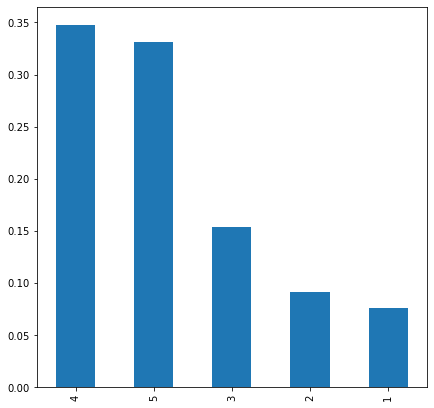

In [10]:
#Plotting distributions of stars 

plt.figure(figsize=(7,7))

reviews['stars'].value_counts(1).plot(kind='bar')

- 4 is the most common star that users give
- About **68% of reviews are positive with 5 or 4 stars** 
- About 32% of reviews has 3 or below stars

#### Q6. What restaurant should we recommend to a new user who does not have a review history?

This kind of problem is known as the **cold start** problem. In this case, we don't have any interactions history by the user as the user is new. So the best recommendation, in this case, is to provide the most popular recommendations based on average stars.

### Rank based recommendation system

As we have see before, the restaurant: **Pita Jungle** has been interacted the most. Let's check the distribution of stars for the business below: 

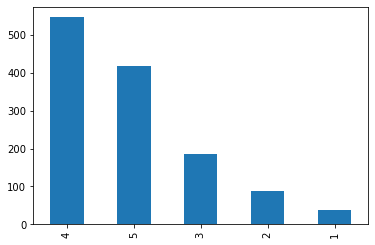

In [11]:
reviews[reviews['business_name'] == 'Pita Jungle']['stars'].value_counts().plot(kind='bar')

- As we can see this business has been a liked restaurant as the count of stars 5 and 4 are higher than the remaining stars. 
- There might be some businesses with very high interactions but 1 and 2 stars may be much higher than 4 or 5 i.e. that business is the most disliked business.

So to build the rank based recommendation system, let's take **average** of all the stars provided to each business and then rank them based on their average stars

In [12]:
#Calculating average stars
average_stars = reviews.groupby('business_name').mean()['stars']

#Calculating the count of stars
count_star = reviews.groupby('business_name').count()['stars']

#Making a dataframe with the count and average of stars
final_review = pd.DataFrame({'avg_review':average_stars, 'review_count':count_star})

In [13]:
final_review.head()

,avg_review,review_count
business_name,,
#1 Brother's Pizza,4.333333,9
1 Brother's Pizza,1.000000,4
1 Brothers Inc,2.538462,13
1 Obi Nail Spa,2.166667,6
101 Bistro,3.285714,7


Now, let's create a function to find the **top n businesses** for a recommendation based on the average stars of all businesses. We can also add a **threshold for a minimum number of interactions** for a business to be considered for recommendation.

In [14]:
def top_n_businesses(data, n, min_interaction=100):
    
    #Finding businesses with minimum number of interactions
    recommendations = data[data['review_count'] > min_interaction]
    
    #Sorting values w.r.t average stars
    recommendations = recommendations.sort_values(by='avg_review', ascending=False)
    
    return recommendations.index[:n]

We can **use this function with different n's and minimum interactions** to get businesses to recommend

#### Recommending top 5 businesses with 50 minimum interactions based on popularity

In [15]:
list(top_n_businesses(final_review, 5, 50))

['FROST A Gelato Shoppe',
 "That's Amore Gelato",
 'HTC Body Piercing',
 "Penzey's Spices",
 'Café Monarch']

#### Recommending top 5 businesses with 100 minimum interactions based on popularity

In [16]:
list(top_n_businesses(final_review, 5, 100))

['Café Monarch',
 'Short Leash Dogs',
 'Paletas Betty',
 'Changing Hands Bookstore',
 'The Deli']

#### Recommending top 5 businesses with 500 minimum interactions based on popularity

In [17]:
list(top_n_businesses(final_review, 5, 500))

['Postino Arcadia',
 'Cornish Pasty Company',
 'Cibo',
 'Four Peaks Brewing Co',
 "Joe's Farm Grill"]

Now that we have seen how to apply the Rank-Based Recommendation System to solve the cold start problem. Now, let's see the Collaborative Filtering Based Recommendation System

### Collaborative Filtering

#### Types of Collaborative Filtering

- Similarity/Neighborhood based
- Model based

#### Building Similarity/Neighborhood based Collaborative Filtering

To build collaborative filtering recommendation system, we need to create **user-item interactions matrix**. Since this dataset is big, we will make a shorter version of this dataset by filtering to 1000 most rated businesses and top 1000 users who has interacted the most.

In [18]:
#Finding IDs of top 1000 businesses
top_1000_businesses = pd.DataFrame({'business_id':reviews['business_id'].value_counts()[:1000].index})
top_1000_businesses.head()

,business_id
0,8254
1,5947
2,3830
3,9425
4,2852


In [19]:
#Finding IDs of top 1000 users
top_1000_users = pd.DataFrame({'user_id':reviews[reviews['business_id'].isin(top_1000_businesses['business_id'])]['user_id'].value_counts()[:1000].index})
top_1000_users.head()

,user_id
0,31258
1,7236
2,4179
3,1196
4,3371


In [20]:
#Filtering the original data to contain only top 1000 businesses
reviews_small = top_1000_businesses.merge(reviews, how='inner', on='business_id')
reviews_small.shape

(123460, 4)

In [21]:
#Filtering the data with top 1000 businesses to contain only top 1000 users
reviews_small = top_1000_users.merge(reviews_small, how='inner', on='user_id')
reviews_small.shape

(42958, 4)

In [22]:
reviews_small.head()

,user_id,business_id,business_name,stars
0,31258,8254,Phoenix Sky Harbor International Airport,3
1,31258,3830,Four Peaks Brewing Co,4
2,31258,9425,Matt's Big Breakfast,4
3,31258,2852,FEZ,5
4,31258,5852,Cibo,5


Let's compute the **user-item interactions matrix**

In [23]:
interactions_matrix = reviews_small.pivot(index='user_id', columns='business_id', values='stars')

In [24]:
interactions_matrix

business_id,11,12,13,36,39,51,88,103,126,140,...,11433,11446,11495,11504,11506,11509,11517,11521,11529,11531
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,4.0,NaN,NaN,NaN,3.0
45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
111,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45742,3.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,4.0,NaN,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- This is a very **sparse matrix**. 

We will find out the most similar users using this matrix but first we need to replace the missing values with 0 values.

In [25]:
interactions_matrix.fillna(0, inplace=True)
interactions_matrix.head()

business_id,11,12,13,36,39,51,88,103,126,140,...,11433,11446,11495,11504,11506,11509,11517,11521,11529,11531
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,0.0,3.0
45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now, let's create a **function to find similar users and similarity scores for given userID and interaction matrix**

In [26]:
def similar_users(user_id, interactions_matrix):
    similarity = [] 
    for user in interactions_matrix.index:
        
        #finding cosine similarity between the user_id and each user
        sim = cosine_similarity([interactions_matrix.loc[user_id]], [interactions_matrix.loc[user]])
        
        #Appending the user and the corresponding similarity score with user_id as a tuple 
        similarity.append((user, sim))
        
    similarity.sort(key=lambda x: x[1], reverse=True)   #Sorting the list on the basis of similarity scores
    
    most_similar_users = [tup[0] for tup in similarity] #Extracting the user from each tuple in the sorted list
    
    similarity_score = [tup[1] for tup in similarity]   #Extracting the similarity score from each tuple in the sorted list
    
    most_similar_users.remove(user_id)                  #Removing the original user and keeping only other similar users       
    similarity_score.remove(similarity_score[0])
       
    return most_similar_users, similarity_score

#### Finding out top 10 similar users to the userID 87 and their similarity score

In [27]:
similar_users(87, interactions_matrix)[0][:10]

[32677, 41925, 32197, 11704, 21842, 31797, 11756, 823, 660, 2588]

In [28]:
similar_users(87, interactions_matrix)[1][:10]

[array([[0.2425335]]),
 array([[0.23386363]]),
 array([[0.23118345]]),
 array([[0.23054085]]),
 array([[0.21433346]]),
 array([[0.20585862]]),
 array([[0.19890013]]),
 array([[0.19846943]]),
 array([[0.19021444]]),
 array([[0.18735775]])]

#### Finding out top 10 similar users to the userID 45 and their similarity score

In [29]:
similar_users(45, interactions_matrix)[0][:10]

[168, 9887, 34405, 37045, 21842, 2153, 30360, 43019, 1012, 7236]

In [30]:
similar_users(45, interactions_matrix)[1][:10]

[array([[0.23243065]]),
 array([[0.22341618]]),
 array([[0.21733215]]),
 array([[0.21607569]]),
 array([[0.21571987]]),
 array([[0.20630411]]),
 array([[0.20249907]]),
 array([[0.20036151]]),
 array([[0.19259192]]),
 array([[0.18997788]])]

We have learned how to find similar users for a given user but how do we find which **business to recommend to a particular user?** This is done by finding the **businesses which have been interacted/rated the most by similar users** but not by the user of interest.

**Let's create a function to do the same.**

In [31]:
def recommendations(user_id, num_of_businesses, interactions_matrix, reviews_small):
    
    #Saving similar users using the function similar_users defined above
    most_similar_users = similar_users(user_id, interactions_matrix)[0]
    
    #Finding business IDs with which the user_id has interacted
    business_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[user_id] > 0)]))
    recommendations = []
    
    observed_interactions = business_ids.copy()
    for similar_user in most_similar_users:
        if len(recommendations) < num_of_businesses:
            #Finding 'n' businesses which have been rated by similar users but not by the user_id
            similar_user_business_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[similar_user] > 0)]))
            recommendations.extend(list(similar_user_business_ids.difference(observed_interactions)))
            observed_interactions = observed_interactions.union(similar_user_business_ids)
        else:
            break
            
    business_names = reviews_small[reviews_small['business_id'].isin(recommendations[:num_of_businesses])]['business_name'].unique()
    
    return business_names

Now, we can recommend **`n`** number of businesses to any user using the function defined above 

#### Recommend 5 businesses to userID 87 based on similarity based collaborative filtering

In [32]:
recommendations(87, 5, interactions_matrix, reviews_small)

array(["Carly's Bistro", 'The Arrogant Butcher', 'Phoenix City Grille',
       'Nami', 'World Of Beer'], dtype=object)

#### Recommend 5 businesses to userID 45 based on similarity based collaborative filtering

In [33]:
recommendations(45, 5, interactions_matrix, reviews_small)

array(['House of Tricks', 'Bikini Lounge', 'Rogue Bar',
       'Hana Japanese Eatery', "Lon's At the Hermosa"], dtype=object)

### Model Based Collaborative Filtering - Matrix Factorization

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

SVD is used to compute the latent features from the user-item matrix that we already learned earlier. We can find the decomposition using the **`svd() function`** from the linalg module of the NumPy library.

In [34]:
u, s, vt = np.linalg.svd(interactions_matrix, full_matrices=False)

In [35]:
u.shape

(1000, 1000)

In [36]:
s.shape

(1000,)

In [37]:
vt.shape

(1000, 1000)

Now, we need to find the appropriate K to use in order to re-generate the interaction matrix and make predictions. We will split the data into **train and test data** and make predictions for different value of K. We will choose the K which gives good performance on the train and test data.

Now, let's split the data into **train and test data**

In [38]:
X_train, X_test = train_test_split(reviews_small, test_size=0.2, random_state=42)

In [39]:
X_train.shape

(34366, 4)

In [40]:
X_test.shape

(8592, 4)

Let's create the **train and test interactions matrices**

In [41]:
#Train interaction matrix
interactions_matrix_train = X_train.pivot(index='user_id', columns='business_id', values='stars')
interactions_matrix_train.fillna(0, inplace=True)

In [42]:
interactions_matrix_train.shape

(1000, 1000)

In [43]:
#Test interaction matrix
interactions_matrix_test = X_test.pivot(index='user_id', columns='business_id', values='stars')
interactions_matrix_test.fillna(0, inplace=True)

In [44]:
interactions_matrix_test.shape

(996, 991)

We will use the **interactions_matrix_train** to find U, S, and V transpose using SVD. Then find the subset of rows in the **interactions_matrix_test** dataset which we can predict using this matrix decomposition with different numbers of latent features.

In [45]:
#Finding unique users in train and test data and then taking their intersection i.e. common users in train and test data 
train_idx = set(interactions_matrix_train.index)
test_idx = set(interactions_matrix_test.index)
match_idx = train_idx.intersection(test_idx)
    
#Finding unique businesses in train and test data and then taking their intersection i.e. common businesses in train and test data 
train_business = set(interactions_matrix_train.columns)
test_business = set(interactions_matrix_test.columns)
match_cols = train_business.intersection(test_business)

#Selecting only common users and businesses from the test interaction matrix
interactions_matrix_test = interactions_matrix_test.loc[match_idx, match_cols]

In [46]:
interactions_matrix_test.shape

(996, 991)

Now, let's decompose the **interactions_matrix_train** and **find the U and Vt for the test data** using the common users and businesses in the train and test data

In [47]:
u_train, s_train, vt_train = np.linalg.svd(interactions_matrix_train, full_matrices=False)

In [48]:
#Finding u_test and vt_test matrices using u_train, vt_train and common user/businesses in train and test data
row_idxs = interactions_matrix_train.index.isin(test_idx)
col_idxs = interactions_matrix_train.columns.isin(test_business)
u_test = u_train[row_idxs, :]
vt_test = vt_train[:, col_idxs]

We have calculated U and Vt matrices for the train as well as test data. Now, we need to find the number of latent features that give us the **lowest RMSE on the train and the test data**.

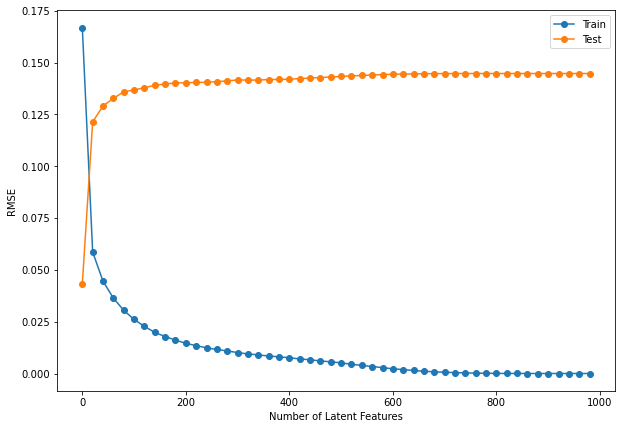

In [49]:
#Creating array for number of latent features and empty lists to store train and test errors
latent_features = np.arange(0, 1000, 20) 
train_error = []
test_error = []

for k in latent_features:
    #Slicing the U, S, and Vt matrices to get k latent features from train and test data 
    s_train_lat, u_train_lat, vt_train_lat = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_lat, vt_test_lat = u_test[:, :k], vt_test[:k, :]
    
    #Regenerating train and test interaction matrices using k latent features
    interactions_matrix_train_preds = np.around(np.matmul(np.matmul(u_train_lat, s_train_lat), vt_train_lat))
    interactions_matrix_test_preds = np.around(np.matmul(np.matmul(u_test_lat, s_train_lat), vt_test_lat))
    
    #Calculating the actual and predicted average stars for each business in the training data
    avg_star_train = interactions_matrix_train.mean(axis=0)
    avg_star_train_pred = interactions_matrix_train_preds.mean(axis=0)
    
    #Calculating the actual and predicted average stars for each business in the test data
    avg_star_test = interactions_matrix_test.mean(axis=0)
    avg_star_test_pred = interactions_matrix_test_preds.mean(axis=0)
    
    #Calculating train and test RMSE
    train_rmse = mean_squared_error(avg_star_train, avg_star_train_pred, squared=False)
    test_rmse = mean_squared_error(avg_star_test, avg_star_test_pred, squared=False)
    
    train_error.append(train_rmse)
    test_error.append(test_rmse)
    
#Plotting train and test RMSE
plt.figure(figsize=(10,7))
plt.plot(latent_features, train_error, label='Train', marker='o');
plt.plot(latent_features, test_error, label='Test', marker='o');
plt.xlabel('Number of Latent Features');
plt.ylabel('RMSE');
plt.legend();

From the above plot we can see that we got a **reasonable RMSE in both train and test dataset at around latent features=10.** If we increase the latent features it will be overfitted and decreasing the latent features will underfit the model.

Let us now **reconstruct the original interaction matrix using latent features = 10** in the same way as above

In [50]:
s_final, u_final, vt_final = np.diag(s[:10]), u[:, :10], vt[:10, :]
business_predicted_stars = np.around(np.matmul(np.matmul(u_final, s_final), vt_final))
business_predicted_stars = pd.DataFrame(abs(business_predicted_stars), columns = interactions_matrix.columns, index = interactions_matrix.index)
business_predicted_stars.head()

business_id,11,12,13,36,39,51,88,103,126,140,...,11433,11446,11495,11504,11506,11509,11517,11521,11529,11531
user_id,,,,,,,,,,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0
45,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We have the predictions of stars but we need to create a **function to recommend businesses** to the users on the basis of predicted stars for each business

In [51]:
# Recommend businesses with the highest predicted stars

def recommend_business(user_idx, interactions_matrix, preds_df, num_recommendations):
          
    # Get and sort stars given by users from the actual and predicted interaction matrix
    sorted_user_stars = interactions_matrix.loc[user_idx].sort_values(ascending=False)
    sorted_user_predictions = preds_df.loc[user_idx].sort_values(ascending=False)
    
    #Creating a dataframe with actual and predicted stars columns
    temp = pd.concat([sorted_user_stars, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Business'
    temp.columns = ['user_stars', 'user_predictions']
    
    #Filtering the dataframe where actual stars are 0 which implies that the user has not interacted with that business
    temp = temp.loc[temp.user_stars == 0]   
    
    #Recommending businesses with top predicted stars
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended businesses for user(user_id = {}):\n'.format(user_index))
    print(temp['user_predictions'].head(num_recommendations))

Now, let's use the function defined above to **recommend businesses to a user**

In [52]:
user_index = 31258
num_recommendations = 5
recommend_business(user_index, interactions_matrix, business_predicted_stars, num_recommendations)


Below are the recommended businesses for user(user_id = 31258):

Recommended Business
6999    4.0
7222    4.0
5947    4.0
175     4.0
3890    3.0
Name: user_predictions, dtype: float64


We can also **calculate the RMSE** for the final stars predicted using the model-based recommendation system. 

In [53]:
#creating a dataframe containing average actual stars and avearge predicted stars of the business
rmse_df = pd.concat([interactions_matrix.mean(), business_predicted_stars.mean()], axis=1)
rmse_df.columns = ['Avg_actual_stars', 'Avg_predicted_stars']
rmse_df

,Avg_actual_stars,Avg_predicted_stars
business_id,,
11,0.248,0.213
12,0.066,0.004
13,0.272,0.212
36,0.109,0.017
39,0.548,0.576
...,...,...
11509,0.488,0.466
11517,0.168,0.055
11521,0.035,0.001


In [54]:
RMSE = mean_squared_error(rmse_df['Avg_actual_stars'], rmse_df['Avg_predicted_stars'], squared=False)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.06936969078783616 



- The **RMSE is low** which implies that the majority of **predicted stars are close to the actual stars**

### Conclusion

In this case study, we saw three different ways of building recommendation systems: 
- rank-based using averages
- similarity based collaborative filtering
- model-based (matrix factorization) based collaborative filtering

We also understood the advantages/disadvantages of these recommendation systems and when to use which kind of recommendation systems. Once we build these recommendation systems, we can use **A/B Testing** to measure the effectiveness of these systems.